# Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning

import mnist_loader

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Carregando o MNIST dataset

In [3]:
# Loading MNIST dataset
training_data, validation_data, test_data = mnist_loader.load_data()

X_train, Y_train = np.concatenate((training_data[0], validation_data[0])), np.concatenate((training_data[1], validation_data[1]))
X_test, Y_test = test_data[0], test_data[1]

# Definindo os parâmetros da MLP

Os parâmetros testados em busca do melhor desempenho estão descritos abaixo:
<br>
- Número de camadas: Definido aleatoriamente para cada experimento, de forma que cada MLP testado terá 1 ou mais camadas ocultas, com cada camada sendo adicionada caso o número aleatório retornado pelo random.uniform seja maior do que 0.6
- Número de neurônios: Também definido aleatoriamente para cada experimento e camada, sendo um número entre 2 e 100
- Taxa de aprendizagem: Número definido de forma aleatória entre 0.001 e 0.1, tendo no máximo 4 dígitos
- Função de ativação: Escolhido aleatoriamente, podendo ser 'identity', 'logistic', 'tanh' ou 'relu'
- Algoritmo de aprendizagem: Também escolhido aleatoriamente, podendo ser 'adam', 'sgd' ou 'lbfgs'

In [4]:
# Definir a quantidade de camadas escondidas
def random_hidden_layers():
    hidden_layer = [random.randint(2, 100)]
    while random.uniform(0.0, 1.0) > 0.4:
        hidden_layer.append(random.randint(2, 100))
    return hidden_layer

def random_params_mlp(verbose=False, num_epochs=1000, tol=0.0001):
    return MLPClassifier(
        activation=random.choice(['identity', 'logistic', 'tanh', 'relu']),
        batch_size=100,
        early_stopping=True,
        hidden_layer_sizes=random_hidden_layers(),
        learning_rate_init=round(random.uniform(0.0001, 0.1), 4),
        max_iter=num_epochs,
        n_iter_no_change=3,
        solver=random.choice(['adam', 'sgd', 'lbfgs']),
        tol=tol
    )

# Fazendo um "GridSearch" sobre a camada escondida

Foram realizados 25 experimentos, cada um com parâmetros diferentes e escolhidos aleatoriamente usando a biblioteca random, que é nativa do python, com os 3 modelos com maior acurácia total sendo salvos e exibidos ao fim todos os experimentos.

In [5]:
trained_models = []

print("Activation | Solver | LR | Hidden Layers: Accuracy | Total Time")
for _ in range(25):
    mlp = random_params_mlp()

    start = time.time()
    mlp.fit(X_train, Y_train)
    end = time.time()
    total_time = round(end - start, 1)

    mlp_predictions = mlp.predict(X_test)
    accuracy = accuracy_score(Y_test, mlp_predictions)
    print(f"{mlp.get_params()['activation']} | {mlp.get_params()['solver']} | {mlp.get_params()['learning_rate_init']} \
| {mlp.get_params()['hidden_layer_sizes']}: {accuracy} | {total_time}s")

    trained_models.append((mlp, accuracy))
    trained_models = sorted(trained_models, key=lambda tup: tup[1], reverse=True)[:3]


print("\nTop 3 Models:")
for model, acc in trained_models:
    print(f"Accuracy: {acc}, Params: {model.get_params()['hidden_layer_sizes']}")

Activation | Solver | LR | Hidden Layers: Accuracy | Total Time
relu | sgd | 0.046 | [82, 15, 92, 28, 8]: 0.973 | 21.7s
identity | lbfgs | 0.0326 | [47, 68, 80]: 0.9212 | 370.6s
logistic | sgd | 0.0821 | [82]: 0.9765 | 25.0s
logistic | lbfgs | 0.0064 | [35, 93]: 0.957 | 208.5s
relu | lbfgs | 0.0535 | [89, 9]: 0.97 | 122.5s
logistic | lbfgs | 0.0998 | [57, 43, 84, 77]: 0.1135 | 10.9s
logistic | adam | 0.0239 | [34, 26]: 0.9469 | 7.6s
identity | lbfgs | 0.0336 | [86, 13]: 0.9213 | 369.2s
identity | lbfgs | 0.0031 | [5, 42, 89, 93, 41, 97, 44]: 0.9025 | 539.9s
identity | sgd | 0.0676 | [51]: 0.9189 | 9.6s
identity | sgd | 0.0447 | [16, 64, 31, 53]: 0.91 | 6.2s
identity | adam | 0.0235 | [45]: 0.8959 | 13.8s
logistic | adam | 0.0118 | [21]: 0.9482 | 5.2s
tanh | sgd | 0.0371 | [98]: 0.9779 | 36.6s
relu | adam | 0.0261 | [37]: 0.9465 | 12.1s
identity | lbfgs | 0.0961 | [89, 96]: 0.922 | 635.0s
identity | sgd | 0.0399 | [90]: 0.9226 | 9.7s
identity | adam | 0.0854 | [82]: 0.8952 | 27.6s
ident

Acima temos os parâmetros para cada um dos 25 Multilayer Perceptrons testados, junto com sua acurácia total e o tempo que levou para treinar cada um deles. <br>
Nota-se que a maioria dos modelos apresentam uma acurácia parecida, com excessão de alguns modelos que possuem 4 camadas ocultas, com o restante dos modelos apresentando uma acurácia total maior do que 0.89.

# Análise da Performance Sobre o Conjunto de Teste

Feita a previsão do modelo com os dados do conjunto de teste, foi calculado a acurácia, precisão e recall total usando ...

In [6]:
best_model = trained_models[0][0]

In [7]:
mlp_predictions = best_model.predict(X_test)

## Calculando Acurácia, Precisão e Recall

In [8]:
accuracy = accuracy_score(Y_test, mlp_predictions)
precision = precision_score(Y_test, mlp_predictions, average='weighted')
recall = recall_score(Y_test, mlp_predictions, average='weighted')


In [9]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}") # PRECISA AJUSTAR O PRECISION E O RECALL PARA MULTICLASS
print(f"Recall: {recall}")

Accuracy: 0.9779
Precision: 0.9779068625361591
Recall: 0.9779


In [ ]:
#Pegando o report de cada classe 
report = classification_report(Y_test, mlp_predictions, target_names=['0','1','2','3','4','5','6','7','8','9'], output_dict = True)
conf_matrix = confusion_matrix(Y_test, mlp_predictions )
# Calcular a acurácia para cada classe
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i in range(10):
  report[str(i)]['accuracy'] = accuracy_per_class[i]

#Printando a tabela
df = pd.DataFrame(report)
df_inverted = df.transpose()
df = df.drop(columns=['accuracy', 'macro avg', 'weighted avg'])
df

## Plotando a Matrix de Confusão

Também foi exibido a matrix de confusão abaixo de forma a termos uma ideia da performance do melhor modelo para cada uma das suas 10 classes.

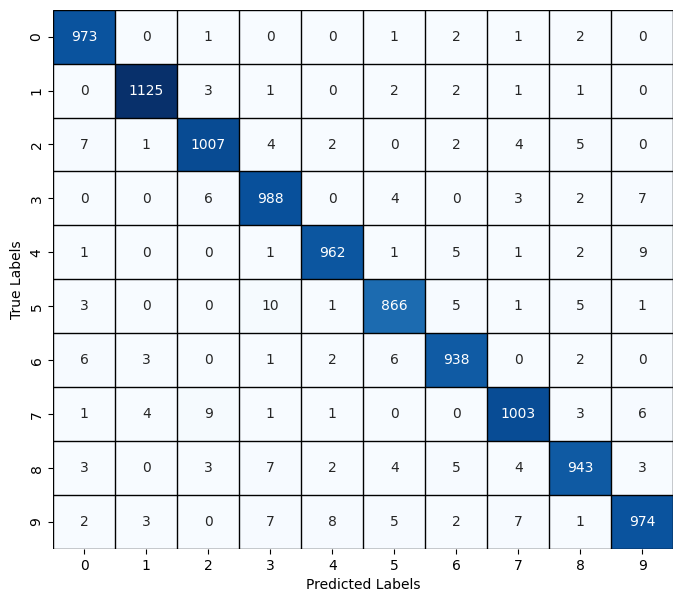

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, mlp_predictions)
plt.figure(figsize=(8, 7))

# Heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(10), yticklabels=range(10))

# Labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(11):
    plt.hlines(i, xmin=0, xmax=10, colors='black', linestyles='solid', linewidth=1)
    plt.vlines(i, ymin=0, ymax=10, colors='black', linestyles='solid', linewidth=1)

plt.show()

Observa-se que o modelo tem uma performance boa em todas as classes, acertando a maioria dos casos de teste, errando principalmente os dígitos 8 e 9, onde mais de 30 instâncias foram classificadas incorretamente, porém com 943 e 974, respectivamente, sendo classificadas corretamente.

## Média e Desvio Padrão das Métricas

Por último, iremos calcular a média e desvio padrão dos 3 melhores conjuntos de parâmetros para ter um melhor entendimento do quão bom é a performance dos modelos treinados com esses parâmetros.

In [11]:
data = {
    'Params': [],
    'Mean Accuracy': [],
    'Std Accuracy': [],
    'Mean Precision': [],
    'Std Precision': [],
    'Mean Recall': [],
    'Std Recall': [],
    'Mean Time': [],
    'Std Time': [],
}

In [13]:
# Criando 10 modelos para as 3 melhores combinações de parâmetros
for i, model in enumerate(trained_models):
    model = model[0]
    accuracy = []
    precision = []
    recall = []
    fit_time = []
    for _ in range(10):
        start = time.time()
        model.fit(X_train, Y_train)
        end = time.time()
        fit_time.append(round(end - start, 1))

        model_predictions = model.predict(X_test)
        accuracy.append(accuracy_score(Y_test, model_predictions))
        precision.append(precision_score(Y_test, model_predictions, average='weighted'))
        recall.append(recall_score(Y_test, model_predictions, average='weighted'))

    data['Params'].append(f"C{i}")
    data['Mean Accuracy'].append(np.mean(accuracy))
    data['Std Accuracy'].append(np.std(accuracy))
    data['Mean Precision'].append(np.mean(precision))
    data['Std Precision'].append(np.std(precision))
    data['Mean Recall'].append(np.mean(recall))
    data['Std Recall'].append(np.std(recall))
    data['Mean Time'].append(np.mean(fit_time))
    data['Std Time'].append(np.std(fit_time))
df = pd.DataFrame(data)

In [14]:
df

,Params,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean Time,Std Time
0,C0,0.97683,0.000901,0.976859,0.000902,0.97683,0.000901,28.81,7.403033
1,C1,0.97634,0.001495,0.976397,0.001471,0.97634,0.001495,37.78,13.159240
2,C2,0.97539,0.001078,0.975430,0.001063,0.97539,0.001078,32.52,9.907654


# Salvando o melhor modelo treinado

Nessa secção está o código para salvar o modelo de melhor performance usando o pickle, outra biblioteca nativa do python, para salvar esse modelo em um arquivo .pkl que pode ser aberto posteriormente com o pickle.load(open(caminho_arquivo_pkl, 'rb')).

In [15]:
filename = 'test_model.plk'

In [16]:
# Salvando o modelo em um arquivo
with open(filename, 'wb') as f:
    pickle.dump(best_model, f)

In [17]:
# # Carregando um modelo salvo
# with open(filename, 'rb') as f:
#     best_model = pickle.load(f)